# Group 2 Lab 2
##### Members: Alex Monaghan, Joe Barry, John Hennin, and Matthew Cheng
##### Professor Davis
##### Applied Time Series Analysis
##### 9 April 2021


### 1) Introduction

### 1.1) Outliers
An outlier is, roughly, a data point that differs from the majority in some fashion, whether it be relatively very low, relatively very high, etc. If, for example, you wanted to find the average height of men from ages 19-25 and you took a sample of 10,000 people fitting this description, a 7’5” basketball player in this sample would arguably be an outlier. Similarly, a 3’9” man suffering from dwarfism would also arguably be an outlier. It is usually up to the statistician or data scientist to determine what constitutes outliers. Outliers can distort the features of your data, such as the mean. Dataset A: {2, 3, 8, 6, 5, 5, 7, 4, 4, 4} has an average of 4.8. If you add an (extreme) outlier value of 999,999,999, the average becomes 90,909,095.18, which is obviously far higher than 4.8. Since we depend on these features for data analysis, it’s important to ensure that they are as accurate (i.e. outlier-free) as possible. According to the article, A Brief Overview of Outlier Detection Techniques by Sergio Santoyo, outliers are usually caused by “data entry errors (human errors), measurement errors (instrument errors), and experimental errors (data extraction or experiment planning/executing errors).”

#### 1.2) Peirce's Criterion
Since outliers can potentially greatly affect the arithmetic average of a data set, eliminating potential outliers can be an important step. Peirce’s criterion can be applied to identify multiple outliers and it does not depend on the actual observation data, only its characteristics. This makes it an easily repeatable process that can be calculated independently from other processes.
An assumption that some methods assume is that a measurement should be rejected if the probability of obtaining the deviation from the mean for that value is less than the inverse of twice the number of observations, but peirce’s criterion does not assume this.
Peirce’s criterion essentially works like this:
The proposed observations should be rejected when the probability of the actual deviations from the mean, or system of errors, when including the observations in question is less than that of the system of errors without them multiplied by the probability of making the specified number of more abnormal observations. 
Because the complexity of calculation is very difficult, many people use a table of values based off of Peirce to determine their outliers.
The basic method of determining rejection goes as such:
1. Calculate the mean and the sample standard deviation of the whole data set (including potential outliers)
2. Choose the number of potential outliers you think there are (generally starting with 1 the first time around is a good idea) 
3. Calculate the maximum allowable deviation: R times sample standard deviation . 
4. For any suspicious data measurements, obtain the deviation: absolute value of the data measurement minus the mean. 
5. Eliminate the measurements if the deviation is greater than the maximum allowable 
6. If one measurement is rejected, assume the case of two potential outliers and then go to step 8. 
7. If more than one measurement is rejected, try again with the next highest value (if 4 outliers were rejected, try 5). 
8. Repeat steps 2 – 5, sequentially increasing the number of doubtful measurement possibilities, until no more measurements are rejected. 
9. Obtain the new mean and sample standard deviation from the reduced data set.


#### 1.3) Additional Outlier Identification
Peirce’s criterion forces you to begin at 1 assumed outlier and repeat the process for each additional outlier in the data, which can be computationally costly and just generally tedious given very large datasets. If you’re working with low dimensional data, you can easily just plot the data and visually identify the outliers using your own judgement. Then, you can define a bounding function that discriminates between outliers and legitimate data. Continuing with our previous example of an outlier in Dataset A, you could filter out all values that are greater than 30, which would still consider legitimate extremes, but successfully eliminate the outlier 999,999,999. However, defining a function that filters out outliers could be difficult, as outliers may not be linearly separable from the legitimate data. Peirce’s criterion manages to avoid this issue by meticulously considering each outlier at a time rather than eliminating all of them with one umbrella bounding function.

### 1.4) FLUXNET2015 Dataset
The FLUXNET2015 dataset depicts data that was collected at certain sites from multiple “regional flux networks”.  FLUXNET is defined as a “global activity collaborated and participated voluntarily by local Tower Teams and Regional Networks”.  However, the main contributors to FLUXNET are the local tower teams, and the regional network teams provide additional assistance by “investing their time and energy towards the collection of site information, data harmonization, and data processing”.  The data itself that is being recorded comes from meteorological sensors around the globe that track atmospheric state variables such as temperature, humidity, wind speed, rainfall, and atmospheric carbon dioxide.  This data is tracked on a continuous basis, and can be used to predict weather, climate, and the cycling of carbon and water.

### 2) Methods

### 2.1) Data Collection

In [ ]:
### Data collection code, given in assignment ###
flux.url <- "https://ds-wm.github.io/course/atsa/data/FLX_US-Goo_FLUXNET2015_SUBSET_HH_2002-05_1-4.csv"
df <- read.csv(flux.url)
#summary(df)
lin.mod <- lm(df$NEE_VUT_REF ~ df$SW_IN_F)

### 2.2) Peirce's Criterion

In [ ]:
### Peirce's Criterion code ###

findx <- function(N, k, m) { 
  # method by K. Thomsen (2008)
  # written by C. Dardis and S. Muller (2012)
  # Available online: https://r-forge.r-project.org/R/?group_id=1473
  #
  # Variable definitions:
  # N :: number of observations
  # k :: number of potential outliers to be removed
  # m :: number of unknown quantities
  #
  # Requires the complementary error function, erfc:
  erfc <- function(x) 2 * pnorm(x * sqrt(2), lower.tail = FALSE)
  #
  x <- 1
  if ((N - m - k) <= 0) {
    return(NaN)
    print(NaN)
  }  else {
    x    <- min(x, sqrt((N - m)/k) - 1e-10)
    #
    # Log of Gould's equation B:
    LnQN <- k * log(k) + (N - k) * log(N - k) - N * log(N)
    #
    # Gould's equation D:
    R1   <- exp((x^2 - 1)/2) * erfc(x/sqrt(2))
    #
    # Gould's equation A' solved for R w/ Lambda substitution:
    R2   <- exp( (LnQN - 0.5 * (N - k) * log((N-m-k*x^2)/(N-m-k)) )/k )
    #
    # Equate the two R equations:
    R1d  <- x * R1 - sqrt(2/pi/exp(1))
    R2d  <- x * (N - k)/(N - m - k * x^2) * R2
    #
    # Update x:
    oldx <- x
    x    <- oldx - (R1 - R2)/(R1d - R2d)
    #
    # Loop until convergence:
    while (abs(x - oldx) >= N * 2e-16) {
      R1   <- exp((x^2 - 1)/2) * erfc(x/sqrt(2))
      R2   <- exp( (LnQN - 0.5 * (N - k) * log((N-m-k*x^2)/(N-m-k)) )/k )
      R1d  <- x * R1 - sqrt(2/pi/exp(1))
      R2d  <- x * (N - k)/(N - m - k * x^2) * R2
      oldx <- x
      x    <- oldx - (R1 - R2)/(R1d - R2d)
    }
  }
  return(x)
}

### 2.3) Finding Outliers


Call:
lm(formula = df$NEE_VUT_REF ~ df$SW_IN_F)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.0382  -1.2748   0.5612   2.0835   9.4803 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.495061   0.121450   12.31   <2e-16 ***
df$SW_IN_F  -0.014301   0.000297  -48.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.716 on 1485 degrees of freedom
Multiple R-squared:  0.6096,	Adjusted R-squared:  0.6093 
F-statistic:  2318 on 1 and 1485 DF,  p-value: < 2.2e-16


Number of outliers predicted:  1 
Number of outliers:  16 

Number of outliers predicted:  2 
Number of outliers:  21 

Number of outliers predicted:  3 
Number of outliers:  21 

Number of outliers predicted:  4 
Number of outliers:  22 

Number of outliers predicted:  5 
Number of outliers:  22 

Number of outliers predicted:  6 
Number of outliers:  22 

Number of outliers predicted:  7 
Number of outliers:  22 

Number of outliers predicted:  8 
Number of outliers:  23 

Number of outliers predicted:  9 
Number of outliers:  24 

Number of outliers predicted:  10 
Number of outliers:  25 

Number of outliers predicted:  11 
Number of outliers:  26 

Number of outliers predicted:  12 
Number of outliers:  28 

Number of outliers predicted:  13 
Number of outliers:  28 

Number of outliers predicted:  14 
Number of outliers:  28 

Number of outliers predicted:  15 
Number of outliers:  28 

Number of outliers predicted:  16 
Number of outliers:  28 

Number of outliers predicted:  17

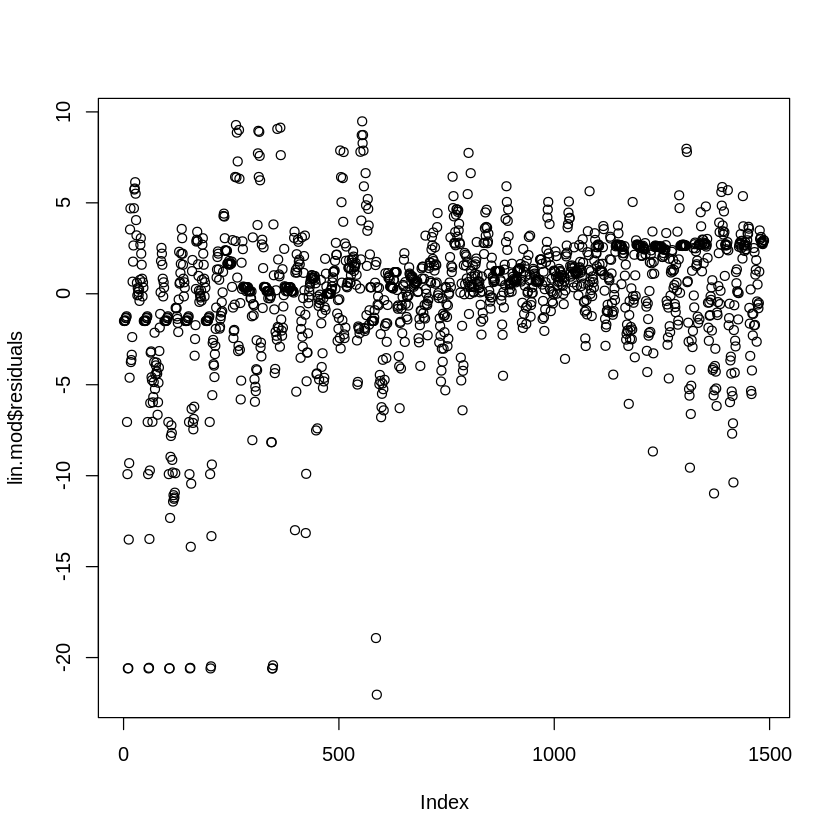

In [ ]:
### Finding outliers ###
summary(lin.mod)
plot(lin.mod$residuals) #To visualize outliers

res <- lin.mod$residuals
sd.res <- sd(res)
#res <- lin.mod$residuals

i <- 1
k <- 1
count <- 2 # Arbitrary, need k < count to start
while (count >= k) {
  indices <- vector()
  otl.dev <- sd.res*findx(length(res), k, 2) #We are using the findx function because it is easier to extract the mean standard error
  count <- 0
  for (obs in res){
    if (obs > otl.dev | obs < -1*otl.dev) {
      count <- count + 1
      indices <- append(indices, i) #Collect the index of the outlier
    }
    i = i + 1
  }
  cat(paste('Number of outliers predicted: ', k, '\nNumber of outliers: ', count, '\n\n'))
  k <- k + 1 # Increase the predicted outliers and run again
  i <- 1 #Need to reset so that next loop doesn't add from where we left off
}

#So, we know that our true number of outliers is 44.

### 2.4) Plotting Residuals

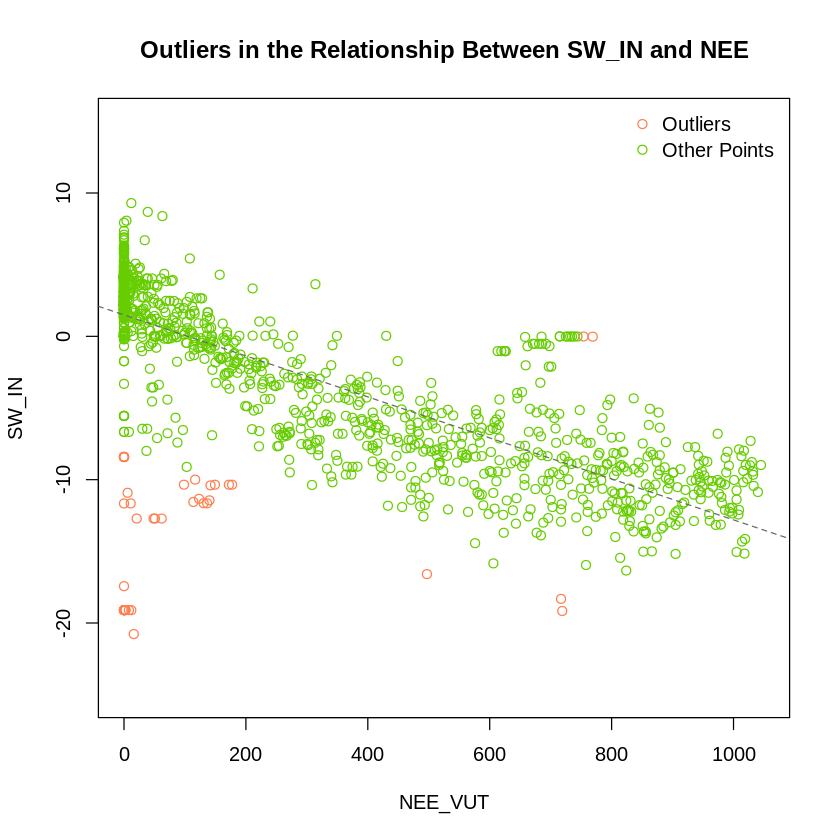

In [ ]:
### Plotting Residuals ###

#Indices is storing our outliers
df$index <- c(1:nrow(df))
otl.sub <- subset(df, df$index %in% indices)
not.otl.sub <- subset(df, !df$index %in% indices)

plot(not.otl.sub$SW_IN_F,
     not.otl.sub$NEE_VUT_REF, 
     xlab = 'NEE_VUT', 
     ylab ='SW_IN', 
     main = 'Outliers in the Relationship Between SW_IN and NEE',
     col = 'chartreuse3',
     xlim=c(0,1050),
     ylim=c(-25,15))
points(otl.sub$SW_IN_F, otl.sub$NEE_VUT_REF, col = 'coral')
#We know from summary(lin.mod) that our best fit line is at y = -.0143x + 1.4951
abline(lin.mod, col = 'dimgray', lty = 2)
legend('topright',legend = c('Outliers', 'Other Points'), bty = 'n', pch = 1, col = c('coral','chartreuse3'))

### 3) Results

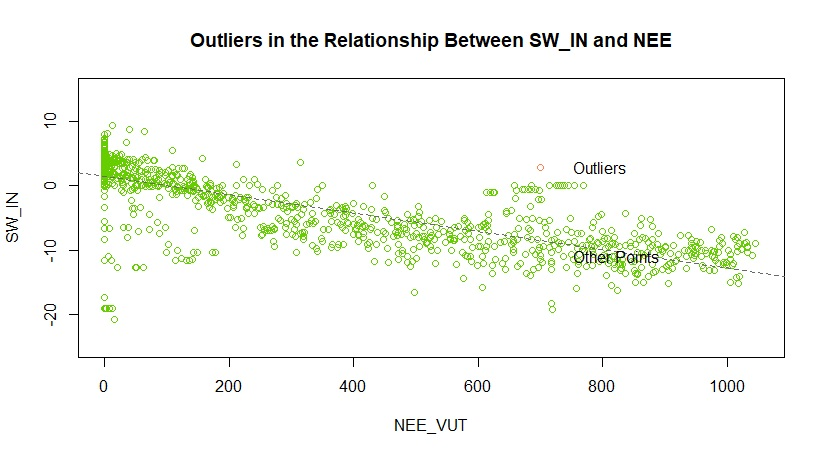

Here, we can see a plot of the relationship between SWin and NEE. SWin is incoming shortwave radiation, or the amount of energy received from the sun. NEE is net ecosystem exchange, or the amount of carbon released or absorbed into our atmosphere. In the plot, we can see many data points, with each being an observation being a measurement from the FLUXNET 2015 dataset. As we can see from the plot, there is an inverse relationship between SWin and NEE. As the amount of incoming shortwave radiation decreases, the amount of carbon released into the atmosphere increases. This can also be seen in the line of best fit, which has the equation: y = -.0143x + 1.4951, where there is a slight negative slope of -.0143 and a y-intercept of 1.4951. In addition, we can see the results of using Peirce’s criterion to find outliers in the dataset. Out of a total 1487 observations, there were 44 data points identified as outliers. In the plot, the outliers can be identified by the orange circles versus the remainder of the dataset being green circles.

### 4) Discussions and Conclusions
We initially plotted the data to visually identify the outliers. This provided us with a rough idea of how many outliers were present in the data. We then used a while loop and two counters, one tracking the number of outliers predicted, K, and another tracking the true number of outliers, count. We used the findx() function written by C. Dardis and S. Muller in 2012 to find outliers until K equaled count and the outliers predicted matched the actual outliers. We found that our true number of outliers is 44, which was roughly what we expected based on the initial visualization. Additionally, by simple definition, outliers tend not to represent a significant portion of the data and 44 outliers out of a collection size of 1487 observations (based on the length of lin.mod$residuals) is arguably insignificant, so our findings are reasonable. We preferred the findx() function over the peirce_dev() function, as the former extracted the mean standard error more easily than the latter. As mentioned above, we found that SWin (short wave energy received from the sun) and NEE (amount of carbon released into the atmosphere) are negatively correlated. This is logically consistent with the theory mentioned in the student notebook (Davis, 2021) according to which the more sunlight that is received by plants, the more carbon is absorbed from the atmosphere by plants (and thus less carbon is in the atmosphere). In order to plot our outliers separately from the rest of the data (so that we could color them differently), we added a line of code after our counter variable, so that if an outlier was found, its index would be appended to a list. Then, we separated the original data frame into outliers and non-outliers using the list of outlier indices as a filter. This allowed us to plot the two groups separately and allowed for easy visualization.

### 5) References


* Peirce's criterion. (2020, December 22). Retrieved April 04, 2021, from 	
	https://en.wikipedia.org/wiki/Peirce%27s_criterion
 
* Ross, S. (2003). Peirce's criterion for the elimination of suspect experimental data. 		Journal of Engineering Technology.
 
* Santoyo, S. (2017, November 24). A brief overview of outlier detection techniques. 		Retrieved April 04, 2021, from 								https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561#:~:text=Most%20common%20causes%20of%20outliers,made%20to%20test%20detection%20methods

* “The Data Portal Serving the FLUXNET Community.” FLUXNET, 18 Feb. 2021, fluxnet.org/.
[Fluxnet Website](https://fluxnet.org)